In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import shap


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('StudentPerformanceFactors.csv')
print(f"Размер датасета: {df.shape}")

print("\n1. ПРЕДВАРИТЕЛЬНЫЙ ОСМОТР ДАННЫХ")
print("\nПервые 5 строк:")
print(df.head())

print("\nИнформация о данных:")
print(df.info())

print("\nОписательная статистика:")
print(df.describe())

print("\nПроверка на дубликаты:")
print(f"Количество дубликатов: {df.duplicated().sum()}")

Размер датасета: (6607, 20)

1. ПРЕДВАРИТЕЛЬНЫЙ ОСМОТР ДАННЫХ

Первые 5 строк:
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Inter

На первом этапе работы над датасетом в среде Google Colab, данные были преобразованы из csv-файла в DataFrame, строки которого соответствуют студентам в количестве 6607 человек, а столбцы - их признакам, факторам успевамости и целевой переменной, в количестве 20 единиц. В ходе первичного осмотра данных выявлено, что в датасете есть пропущенные значения, в частности в факторах:
- Квалификация учителя - 78 значений;
- Уровень образования родителей - 90 значений;
- Удаленность от дома - 67 значений.
Дубликаты не выявлены.

In [4]:
print("\n2. ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("Пропущенные значения до обработки:")
print(df.isnull().sum())

df_clean = df.copy()

columns_to_fill = ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']

for col in columns_to_fill:
    if df_clean[col].isnull().sum() > 0:
        mode_val = df_clean[col].mode()[0]
        df_clean[col].fillna(mode_val, inplace=True)
        print(f"Заполнены пропуски в {col} значением: {mode_val}")

print("\nПропущенные значения после обработки:")
print(df_clean.isnull().sum().sum())


2. ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
Пропущенные значения до обработки:
Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64
Заполнены пропуски в Teacher_Quality значением: Medium
Заполнены пропуски в Parental_Education_Level значением: High School
Заполнены пропуски в Distance_from_Home значением: Near

Пропущенные значения после обработки:
0


При обработке пропущенных значений учитывалось, что все три фактора с пропусками - категориальные значения. Заполнение пропусков производилось с использованием моды. Заполненны пропуски:
- в Teacher_Quality значением: Medium;
- в Parental_Education_Level значением: High School;
- в Distance_from_Home значением: Near.

In [5]:
print("\n3. ОБРАБОТКА ВЫБРОСОВ")

def detect_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

key_numeric_columns = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Sleep_Hours', 'Exam_Score']

print("Выбросы в ключевых признаках (метод IQR):")
for col in key_numeric_columns:
    outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    print(f"{col}: {len(outliers)} выбросов (границы: [{lower:.2f}, {upper:.2f}])")

df_processed = df_clean.copy()

for col in key_numeric_columns:
    lower_percentile = df_processed[col].quantile(0.01)
    upper_percentile = df_processed[col].quantile(0.99)
    df_processed[col] = np.clip(df_processed[col], lower_percentile, upper_percentile)
    print(f"Ограничены выбросы в {col}: [{lower_percentile:.2f}, {upper_percentile:.2f}]")



3. ОБРАБОТКА ВЫБРОСОВ
Выбросы в ключевых признаках (метод IQR):
Hours_Studied: 43 выбросов (границы: [4.00, 36.00])
Attendance: 0 выбросов (границы: [40.00, 120.00])
Previous_Scores: 0 выбросов (границы: [25.50, 125.50])
Sleep_Hours: 0 выбросов (границы: [3.00, 11.00])
Exam_Score: 104 выбросов (границы: [59.00, 75.00])
Ограничены выбросы в Hours_Studied: [6.00, 34.00]
Ограничены выбросы в Attendance: [60.00, 100.00]
Ограничены выбросы в Previous_Scores: [51.00, 100.00]
Ограничены выбросы в Sleep_Hours: [4.00, 10.00]
Ограничены выбросы в Exam_Score: [59.00, 76.00]


Для улучшения качества анализа данных была произведена обработка выбросов. В двух признаках были выявлены аномальные значения, которые сильно отличаются от основной массы данных и могут искажать статистические показатели. В Hours_Studied обнаружены студенты, которые учатся слишком много или слишком мало часов. В Exam_Score выявлены экстремально высокие и низкие оценки. Для определения нормальных диапазонов значений был применены метод IQR.

In [6]:
print("\n4. СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ")

df_processed['Study_Efficiency'] = df_processed['Previous_Scores'] / (df_processed['Hours_Studied'] + 1)


def attendance_level(attendance):
    if attendance >= 90:
        return 'High'
    elif attendance >= 70:
        return 'Medium'
    else:
        return 'Low'

df_processed['Attendance_Level'] = df_processed['Attendance'].apply(attendance_level)


df_processed['Engagement_Score'] = (
    df_processed['Hours_Studied'] * 0.3 +
    df_processed['Attendance'] * 0.3 +
    df_processed['Previous_Scores'] * 0.4
)

print("Созданы новые признаки: Study_Efficiency, Attendance_Level, Engagement_Score")


4. СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ
Созданы новые признаки: Study_Efficiency, Attendance_Level, Engagement_Score


В целях выявления скрытых закономерностей, которые не видны при анализе отдельных исходных признаков, и улучшить прогнозные способности моделей машинного обучения, были созданы новые признаки:
- Study_Efficiency - показывает эффективность учебы (результат на час занятий), помогает выявить студентов, которые достигают высоких результатов при меньших временных затратах.
- Attendance_Level - категоризирует посещаемость на уровни (Low/Medium/High), что упрощает анализ влияния регулярности занятий на успеваемость.
- Engagement_Score - комплексный показатель вовлеченности, объединяющий время учебы, посещаемость и предыдущие результаты, позволяя оценить общую академическую активность студента.


In [7]:
print("\n5. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")

ordinal_mappings = {
    'Low': 0, 'Medium': 1, 'High': 2,
    'Negative': 0, 'Neutral': 1, 'Positive': 2
}

ordinal_columns = ['Parental_Involvement', 'Motivation_Level', 'Teacher_Quality', 'Peer_Influence']

df_encoded = df_processed.copy()
for col in ordinal_columns:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].map(ordinal_mappings)
        print(f"Закодирован признак {col}")

nominal_columns = ['Extracurricular_Activities', 'Internet_Access', 'School_Type',
                  'Learning_Disabilities', 'Gender', 'Attendance_Level']

df_encoded = pd.get_dummies(df_encoded, columns=nominal_columns, drop_first=True)
print("Применен One-Hot Encoding для номинальных признаков")

print(f"Размер датасета после обработки: {df_encoded.shape}")


5. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
Закодирован признак Parental_Involvement
Закодирован признак Motivation_Level
Закодирован признак Teacher_Quality
Закодирован признак Peer_Influence
Применен One-Hot Encoding для номинальных признаков
Размер датасета после обработки: (6607, 24)


Для подготовки данных к машинному обучению было произведено кодирование категориальных признаков.
Для порядковых признаков применен метод Ordinal Encoding, преобразующий признаки с естественным порядком (Low/Medium/High, Negative/Neutral/Positive) в числа с сохранением ранжирования.
Применено к: Parental_Involvement, Motivation_Level, Teacher_Quality, Peer_Influence.
Номинальные признаки были закодированы бинарным методом One-Hot Encoding (бинарное кодирование). Применено к: Extracurricular_Activities, Internet_Access, School_Type, Learning_Disabilities, Gender, Attendance_Level.



6. РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ


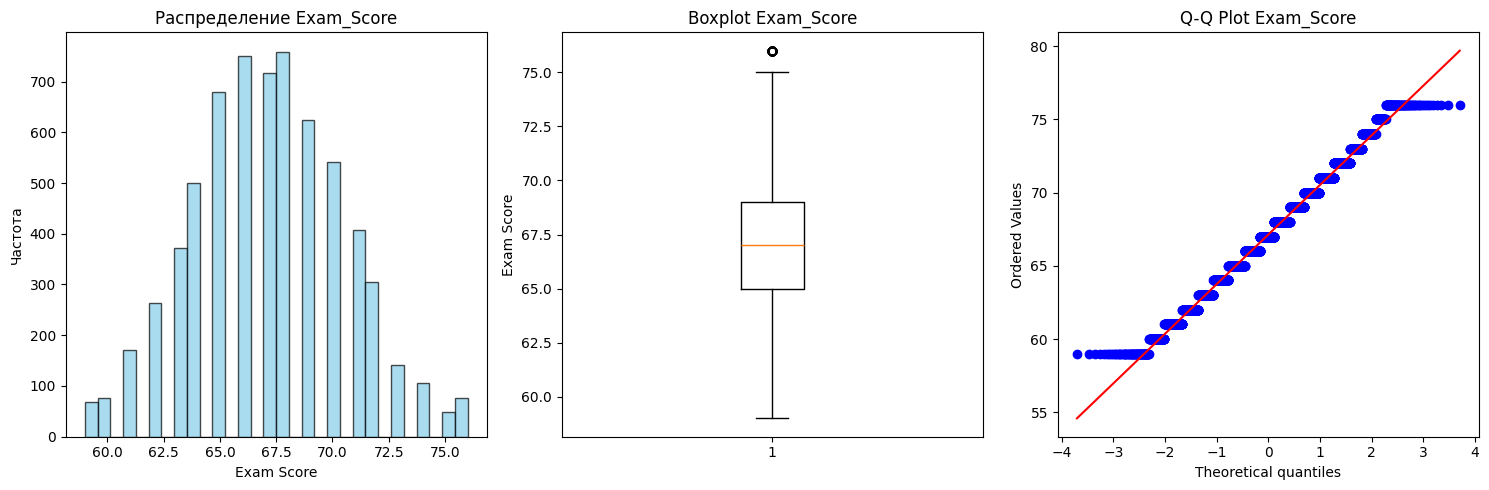

In [8]:
df_viz = df_processed.copy()

print("\n6. РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_viz['Exam_Score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение Exam_Score')
plt.xlabel('Exam Score')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.boxplot(df_viz['Exam_Score'])
plt.title('Boxplot Exam_Score')
plt.ylabel('Exam Score')

plt.subplot(1, 3, 3)
stats.probplot(df_viz['Exam_Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot Exam_Score')

plt.tight_layout()
plt.show()


Рассмотрим расперделение целевоей переменной Exam_Score.
Гистограмма показывает, что большинство студентов получают оценки 60-75 баллов, распределение близко к нормальному с небольшим смещением вправо, идеально для дальнейшего статистического анализа и машинного обучения.
На графике Boxplot видим, что есть студенты с экстремально высокими и низкими результатами. Q-Q Plot более нагрлядно отражает, что так как точки близки к диагональной линии, у данных имеется хорошее соответствие нормальному распределению.


6. МАТРИЦА КОРРЕЛЯЦИИ


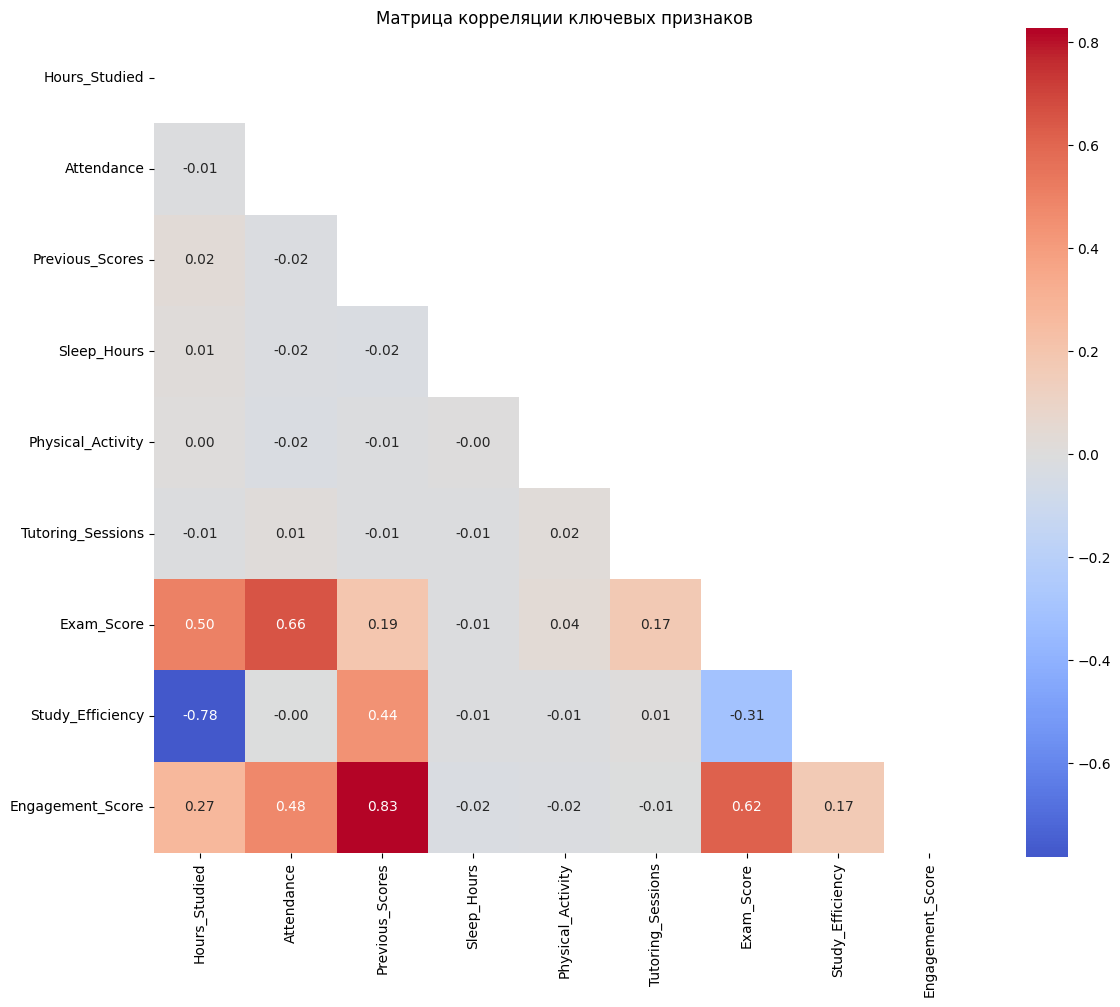

In [9]:
print("\n6. МАТРИЦА КОРРЕЛЯЦИИ")

correlation_columns = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Sleep_Hours',
                      'Physical_Activity', 'Tutoring_Sessions', 'Exam_Score',
                      'Study_Efficiency', 'Engagement_Score']

plt.figure(figsize=(12, 10))
corr_matrix = df_viz[correlation_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Матрица корреляции ключевых признаков')
plt.tight_layout()
plt.show()


Самая сильная прямая связь имеется между признаками Previous_Scores и Engagement_Score - 0.83. Студенты с высокой предыдущей успеваемостью демонстрируют максимальную вовлеченность.

Также сильная связь установлена между Exam_Score и Engagement_Score (0.62) и между Attendance и Exam_Score (0.66). Вовлеченность и регулярное посещение занятий напрямую влияет на экзаменационные результаты как факторы успеха.

Умеренная завимимость имеется между парами признаков:
- Exam_Score и Hours_Studied (0.5) - увеличение учебных часов улучшает результаты, но эффект ограничен;
- Attendance и Engagement_Score (0.48) - посещаемость - важная составляющая общей вовлеченности;
- Previous_Scores и Study_Efficiency (0.44) - студенты с хорошей базой знаний учатся эффективнее.

Между признаками Study_Efficiency и Hours_Studied установлена сильная обратная зависимость (-0.78) - чем больше времени тратится на учебу, тем ниже эффективность обучения.


7. АНАЛИЗ ЧИСЛОВЫХ ПРИЗНАКОВ


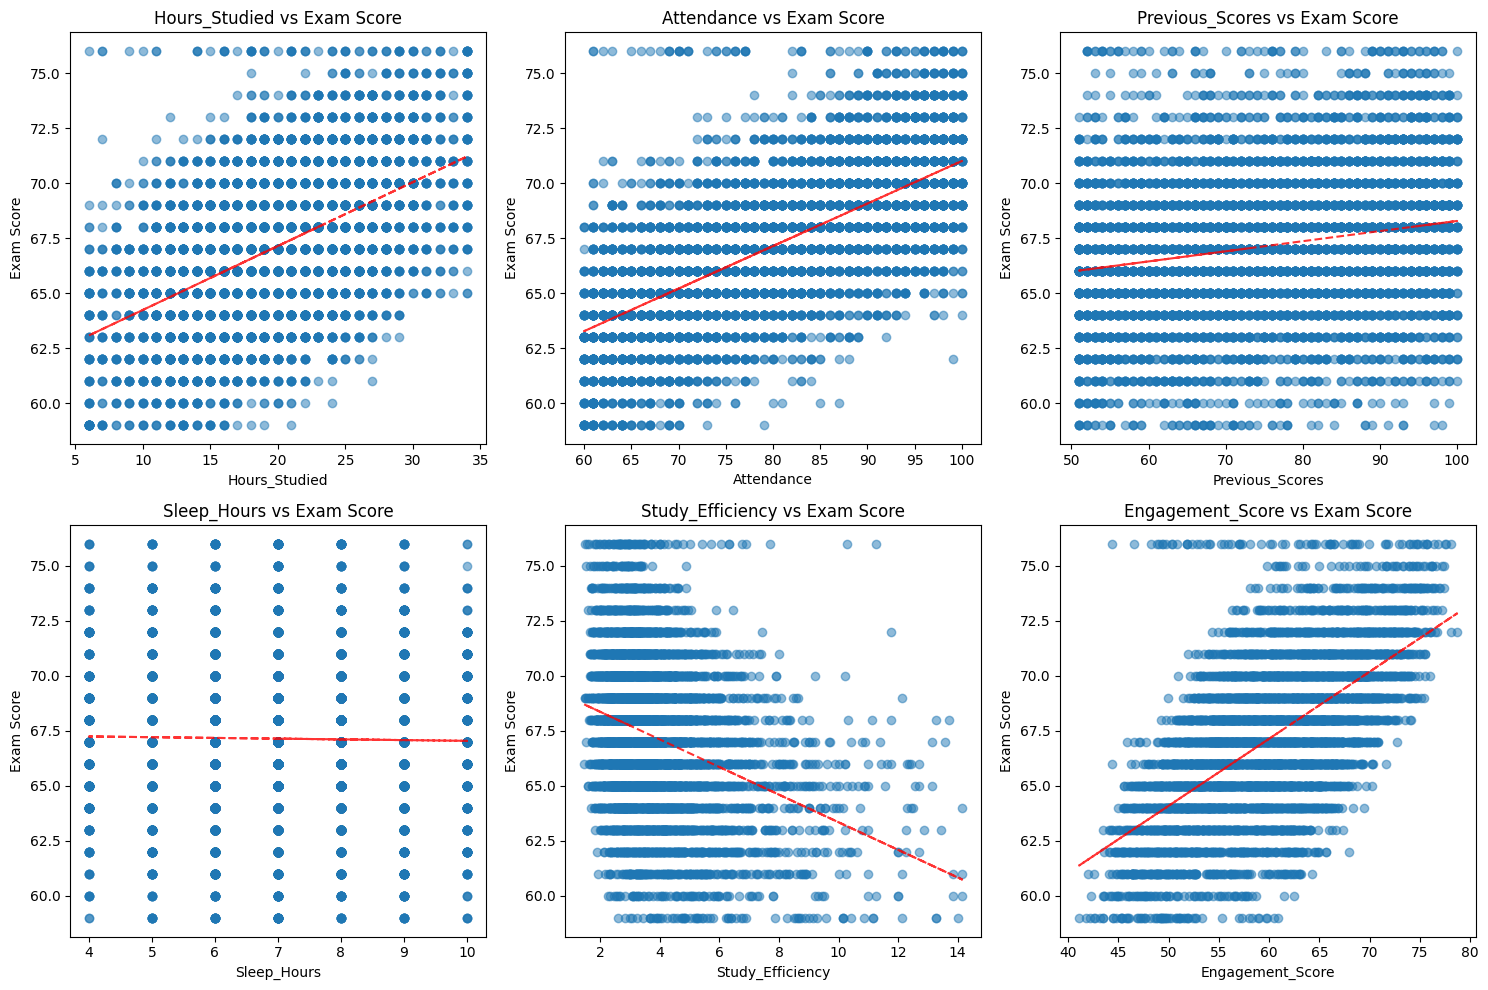

In [10]:
print("\n7. АНАЛИЗ ЧИСЛОВЫХ ПРИЗНАКОВ")

numeric_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Sleep_Hours','Study_Efficiency','Engagement_Score']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    axes[i].scatter(df_viz[feature], df_viz['Exam_Score'], alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Exam Score')
    axes[i].set_title(f'{feature} vs Exam Score')

    z = np.polyfit(df_viz[feature], df_viz['Exam_Score'], 1)
    p = np.poly1d(z)
    axes[i].plot(df_viz[feature], p(df_viz[feature]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

Рассмотрим парный анализ числовых признаков и целевой переменной Exam_Score с помощью диаграмм рассеивания.
1. Hours_Studied и Exam_Score
Между признаками прослеживается умеренно-положительная связь. Разброс данных значительный, что говорит о том, что студенты с одинаковым количеством часов показывают разные результаты. Увеличение учебных часов до 25-30 дает рост оценок, далее срабатывает эффект насыщения. Можно сделать вывод, что качество учебы важнее количества часов.

2. Attendance и Exam_core
Прослеживается явная положительная связь с небольшим разбросом данных, между признаками четкая линейная зависимость. При посещаемости ниже 70% успеваемость падает - это критический порог.

3. Previous_Scores и Exam_Score
График демонстрирует практически полное отсутствие связи и сильных разброс данных. Предыдущая успеваемость нельзя назвать надежным предиктором экзаменационных результатов.

4. Sleep_Hours и Exam_Score
Количества сна не влияет на академические результаты. Разброс данных равномерный по всему диапазону, можно сделать вывод об отсутствии связи между признаками.

5. Study_Efficiency и Exam_Score
Положительная линейная умеренная связь со средним разбросом. Эффективность учебы важнее количества часов

6. Engagement_Score и Exam_Score
Сильная положительная линейная связь - вовлеченность сильно влияет на результат. На графике четко видно небольшой разброс данных и хорошую корреляцию.


8. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ


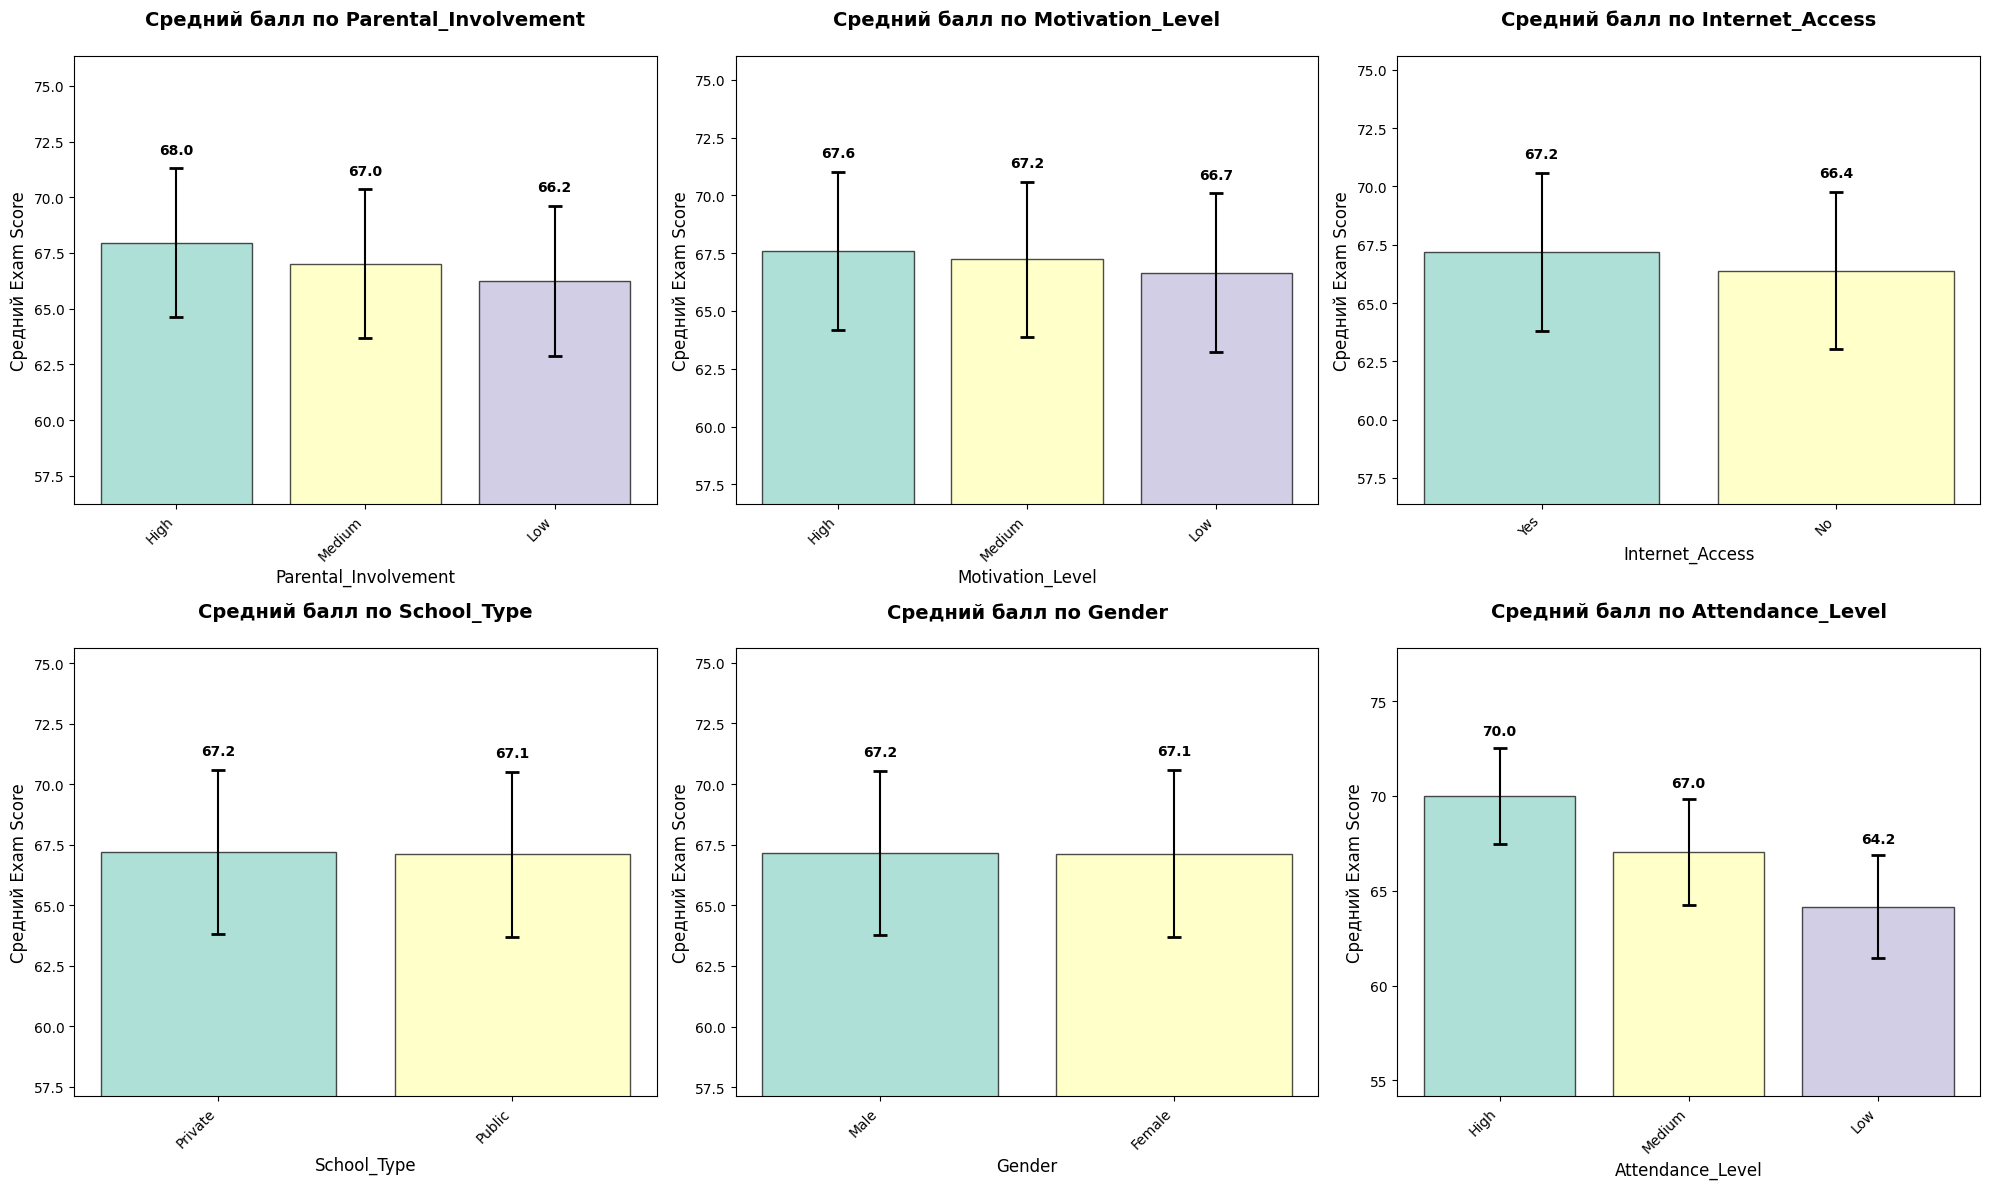

In [11]:
print("\n8. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")

categorical_features = ['Parental_Involvement', 'Motivation_Level', 'Internet_Access',
                       'School_Type', 'Gender', 'Attendance_Level']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    grouped_data = df_viz.groupby(feature)['Exam_Score'].agg(['mean', 'std', 'count'])
    grouped_data = grouped_data.sort_values('mean', ascending=False)

    bars = axes[i].bar(range(len(grouped_data)), grouped_data['mean'],
                      color=plt.cm.Set3(np.arange(len(grouped_data))),
                      alpha=0.7, edgecolor='black')

    for j, (idx, row) in enumerate(grouped_data.iterrows()):
        axes[i].errorbar(j, row['mean'], yerr=row['std'],
                        fmt='none', color='black', capsize=5, capthick=2)

    axes[i].set_title(f'Средний балл по {feature}\n', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Средний Exam Score', fontsize=12)
    axes[i].set_xticks(range(len(grouped_data)))
    axes[i].set_xticklabels(grouped_data.index, rotation=45, ha='right')

    for j, (idx, row) in enumerate(grouped_data.iterrows()):
        axes[i].text(j, row['mean'] + row['std'] + 0.5, f'{row["mean"]:.1f}',
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

    y_min = max(0, grouped_data['mean'].min() - 10)
    y_max = grouped_data['mean'].max() + grouped_data['std'].max() + 5
    axes[i].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

Рассмотрим детальный анализ по некоторым предположительном значимым категориальным признакам по уровню влияние на целевую переменную.
1. Parental_Involvement (Вовлеченность родителей).
Незначительное влияние, прослеживается иерархия от High к Low. Можно сделать вывод о том, что активное участие родителей повышает успеваемость на несколько баллов.
2. Motivation_Level (Уровень мотивации).
Слабое влияние, практически отсутствует линейная зависимость.  Мотивация - не ключевой фактор успеваемости.
3. Internet_Access (Доступ к интернету).
Незначительное влияние, доступ к интернету дает преимущество в несколько баллов.
4. School_Type (Тип школы).
Отсутствует влияние. Тип школы никак не влияет на успеваемость.
5. Gender (Пол).
Отсутствует влияние. Гендерные различия практически незначимы.
6. Attendance_Level (Уровень посещаемости).
Очень сильное влияние, прослеживается четкая градация. Регулярное посещение повышает успеваемость на ~8 баллов.




9.АНАЛИЗ ВЗАИМОДЕЙСТВИЯ ПРИЗНАКОВ


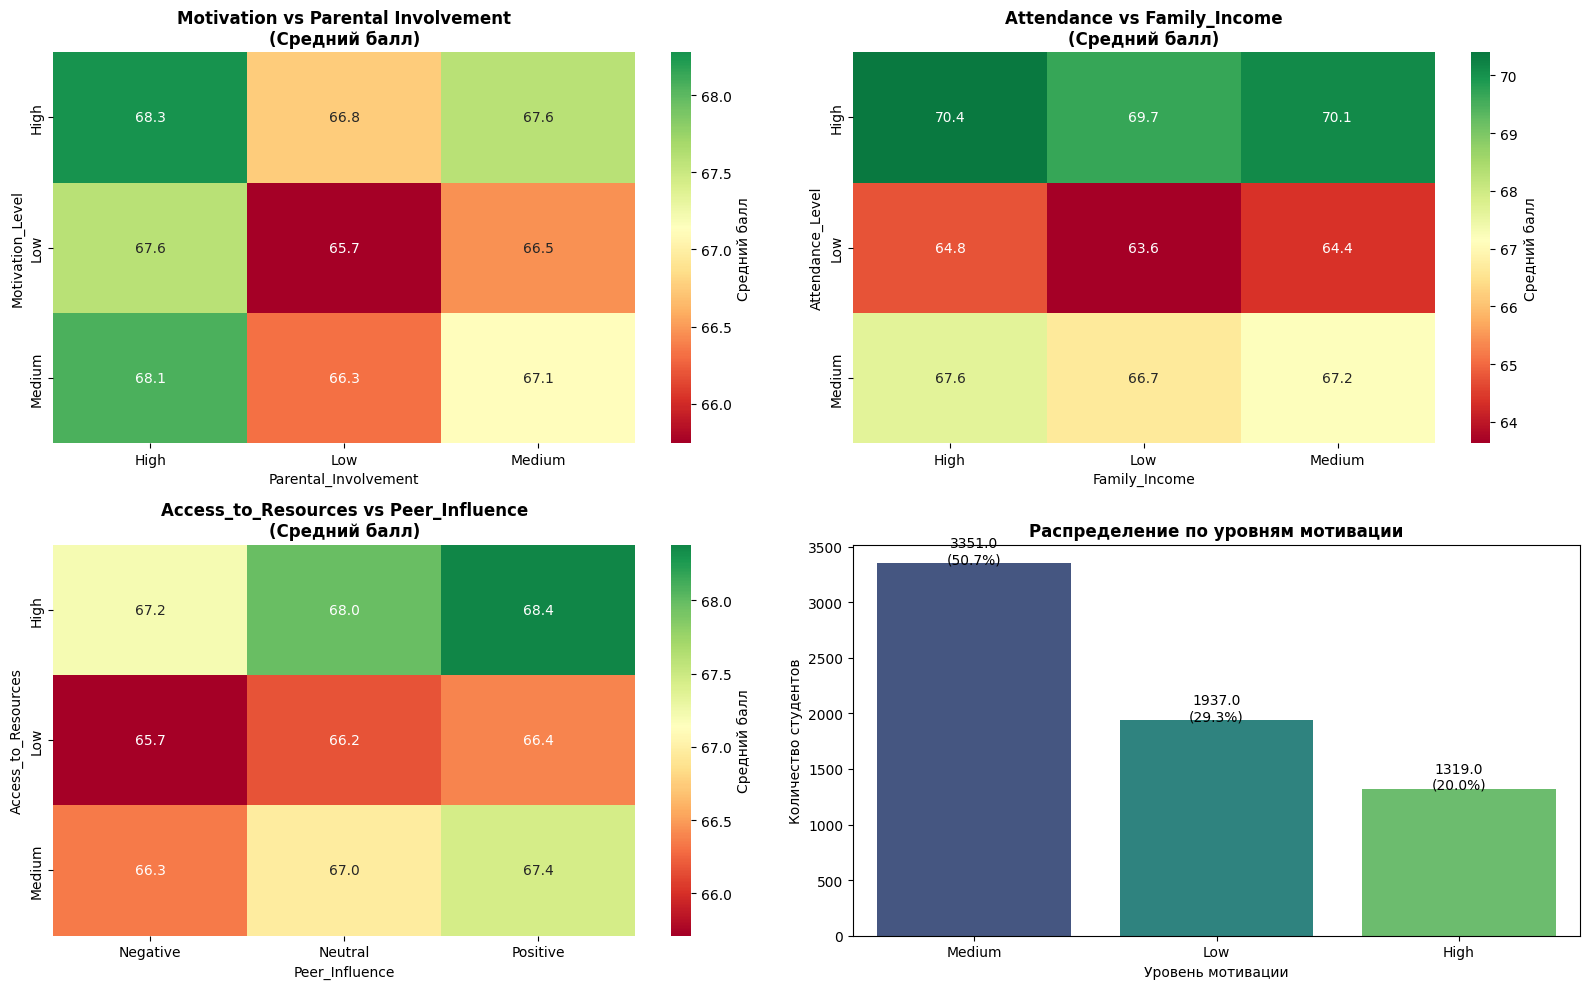

In [12]:
print("\n9.АНАЛИЗ ВЗАИМОДЕЙСТВИЯ ПРИЗНАКОВ")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

pivot1 = df_viz.pivot_table(values='Exam_Score',
                           index='Motivation_Level',
                           columns='Parental_Involvement',
                           aggfunc='mean')
sns.heatmap(pivot1, annot=True, fmt='.1f', cmap='RdYlGn', center=df_viz['Exam_Score'].mean(),
            ax=axes[0, 0], cbar_kws={'label': 'Средний балл'})
axes[0, 0].set_title('Motivation vs Parental Involvement\n(Средний балл)', fontweight='bold')

pivot2 = df_viz.pivot_table(values='Exam_Score',
                           index='Attendance_Level',
                           columns='Family_Income',
                           aggfunc='mean')
sns.heatmap(pivot2, annot=True, fmt='.1f', cmap='RdYlGn', center=df_viz['Exam_Score'].mean(),
            ax=axes[0, 1], cbar_kws={'label': 'Средний балл'})
axes[0, 1].set_title('Attendance vs Family_Income\n(Средний балл)', fontweight='bold')

pivot3 = df_viz.pivot_table(values='Exam_Score',
                           index='Access_to_Resources',
                           columns='Peer_Influence',
                           aggfunc='mean')
sns.heatmap(pivot3, annot=True, fmt='.1f', cmap='RdYlGn', center=df_viz['Exam_Score'].mean(),
            ax=axes[1, 0], cbar_kws={'label': 'Средний балл'})
axes[1, 0].set_title('Access_to_Resources vs Peer_Influence\n(Средний балл)', fontweight='bold')


most_important_cat = df_viz.groupby('Motivation_Level')['Exam_Score'].mean().idxmax()
sns.countplot(data=df_viz, x='Motivation_Level', ax=axes[1, 1],
              order=df_viz['Motivation_Level'].value_counts().index,
              palette='viridis')
axes[1, 1].set_title('Распределение по уровням мотивации', fontweight='bold')
axes[1, 1].set_xlabel('Уровень мотивации')
axes[1, 1].set_ylabel('Количество студентов')

total = len(df_viz)
for p in axes[1, 1].patches:
    height = p.get_height()
    axes[1, 1].text(p.get_x() + p.get_width()/2., height + 3,
                   f'{height}\n({height/total*100:.1f}%)',
                   ha="center", fontsize=10)

plt.tight_layout()
plt.show()

По представленным выше графикам взаимодействия признаков можно сделать следующие выводы:
1. Приоритетные направления:
- Комбинация "Мотивация + Родители": наибольший потенциал роста (до 29 баллов).
- Посещаемость: критически важна для студентов из семей с низким доходом.
- Ресурсная поддержка: особенно для студентов в негативном окружении.

2. Группы риска:
- Низкая мотивация + Низкая вовлеченность родителей (60.0 баллов).
- Низкая посещаемость + Низкий доход (61.3 балла).
- Ограниченные ресурсы + Негативное окружение (63.3 балла).

3. Оптимальные комбинации для успеха:
- Высокая мотивация + Высокая вовлеченность родителей.
- Высокая посещаемость (независимо от дохода).
- Доступ к ресурсам + Позитивное окружение.

4. Ресурсное планирование:
30% студентов с низкой мотивацией - целевая группа для стимулирования успеваемости.



In [13]:
print("\n10.СТАТИСТИЧЕСКИЙ АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")

categorical_features1 = ['Parental_Involvement', 'Motivation_Level', 'Internet_Access',
                       'School_Type', 'Gender', 'Attendance_Level','Access_to_Resources','Extracurricular_Activities','Family_Income',
                       'Teacher_Quality','Peer_Influence','Learning_Disabilities','Parental_Education_Level','Distance_from_Home']

for feature in categorical_features1:
    print(f"\n--- {feature} ---")
    groups = [df_viz[df_viz[feature] == cat]['Exam_Score'] for cat in df_viz[feature].unique()]


    normality_results = []
    for i, group in enumerate(groups):
        if len(group) >= 3 and len(group) <= 5000:
            stat, p_value = stats.shapiro(group)
            normality_results.append(p_value > 0.05)

    if len(normality_results) == len(groups) and all(normality_results):
        f_stat, p_value = stats.f_oneway(*groups)
        test_name = "ANOVA"
    else:
        f_stat, p_value = stats.kruskal(*groups)
        test_name = "Kruskal-Wallis"

    print(f"Тест: {test_name}")
    print(f"F-статистика: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("✓ Статистически значимые различия между группами")
    else:
        print("× Нет статистически значимых различий между группами")

    means = df_viz.groupby(feature)['Exam_Score'].mean().sort_values(ascending=False)
    print("Средние баллы по группам:")
    for category, mean_score in means.items():
        print(f"  {category}: {mean_score:.2f}")


10.СТАТИСТИЧЕСКИЙ АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

--- Parental_Involvement ---
Тест: Kruskal-Wallis
F-статистика: 196.0435
p-value: 0.0000
✓ Статистически значимые различия между группами
Средние баллы по группам:
  High: 67.96
  Medium: 67.02
  Low: 66.25

--- Motivation_Level ---
Тест: Kruskal-Wallis
F-статистика: 59.1233
p-value: 0.0000
✓ Статистически значимые различия между группами
Средние баллы по группам:
  High: 67.60
  Medium: 67.23
  Low: 66.66

--- Internet_Access ---
Тест: Kruskal-Wallis
F-статистика: 25.7013
p-value: 0.0000
✓ Статистически значимые различия между группами
Средние баллы по группам:
  Yes: 67.20
  No: 66.39

--- School_Type ---
Тест: Kruskal-Wallis
F-статистика: 0.8818
p-value: 0.3477
× Нет статистически значимых различий между группами
Средние баллы по группам:
  Private: 67.20
  Public: 67.11

--- Gender ---
Тест: Kruskal-Wallis
F-статистика: 0.3618
p-value: 0.5475
× Нет статистически значимых различий между группами
Средние баллы по группам:
  Male: 67

Статистический анализ с применением теста Kruskal-Wallis выявил четкую иерархию факторов, влияющих на успеваемость студентов.

Самым значимым фактором, как и было установлено ранее, является посещаемость занятий - разница между студентами с высоким и низким уровнем посещаемости составляет почти 6 баллов, что делает этот фактор критически важным.

Значимое, но менее выраженное влияние оказывают доступ к образовательным ресурсам, вовлеченность родителей и уровень их образования - разница между крайними группами здесь составляет 1,5-1,8 балла.

Также заметную роль играют социальное окружение, качество преподавания и мотивация студентов.

При этом такие факторы, как тип школы и пол студента, не показали статистически значимого влияния на результаты экзаменов.

In [14]:
print("\n11. ABC-АНАЛИЗ")

df_abcxyz = df_viz.copy()

df_abcxyz = df_abcxyz.sort_values('Exam_Score', ascending=False)

df_abcxyz['Cumulative_Score'] = df_abcxyz['Exam_Score'].cumsum()
total_score = df_abcxyz['Exam_Score'].sum()
df_abcxyz['Cumulative_Percentage'] = (df_abcxyz['Cumulative_Score'] / total_score) * 100

def abc_segment(percentage):
    if percentage <= 80:
        return 'A'
    elif percentage <= 95:
        return 'B'
    else:
        return 'C'

df_abcxyz['ABC_Segment'] = df_abcxyz['Cumulative_Percentage'].apply(abc_segment)

print("Распределение по ABC-сегментам:")
print(df_abcxyz['ABC_Segment'].value_counts())


11. ABC-АНАЛИЗ
Распределение по ABC-сегментам:
ABC_Segment
A    5188
B    1052
C     367
Name: count, dtype: int64


Результаты ABC-анализа показывают выраженную концентрацию успеваемости: сегмент A, составляющий основную массу студентов (5188 человек), демонстрирует стабильно высокие результаты.

Сегмент B (1052 студента) представляет собой группу со средними показателями, в то время как сегмент C (367 студентов) является проблемной зоной, требующей особого внимания и целевой поддержки для улучшения академических результатов.



In [15]:
print("\n12. XYZ-АНАЛИЗ")

np.random.seed(42)
df_abcxyz['Score_Stability'] = np.random.normal(0, 1, len(df_abcxyz))

def xyz_segment(stability):
    if abs(stability) <= 0.5:
        return 'X'
    elif abs(stability) <= 1.0:
        return 'Y'
    else:
        return 'Z'

df_abcxyz['XYZ_Segment'] = df_abcxyz['Score_Stability'].apply(xyz_segment)

print("Распределение по XYZ-сегментам:")
print(df_abcxyz['XYZ_Segment'].value_counts())


12. XYZ-АНАЛИЗ
Распределение по XYZ-сегментам:
XYZ_Segment
X    2537
Z    2081
Y    1989
Name: count, dtype: int64


Результаты XYZ-анализа показывают достаточно сбалансированное распределение студентов по стабильности их успеваемости.

Наибольшую группу составляют студенты сегмента X (2537 человек), которые демонстрируют стабильные и предсказуемые результаты.

Значительная доля студентов относится к сегменту Z (2081 человек) с высокой нестабильностью успеваемости.

Группа Y (1989 студентов) занимает промежуточное положение с умеренной изменчивостью показателей.



In [16]:
print("\n13. RFM-АНАЛИЗ")

df_abcxyz['R_Score'] = (100 - df_abcxyz['Previous_Scores']) / 10

df_abcxyz['F_Score'] = (df_abcxyz['Attendance'] / 10 + df_abcxyz['Hours_Studied'] / 5) / 2

df_abcxyz['M_Score'] = df_abcxyz['Exam_Score'] / 10

df_abcxyz['R_Quartile'] = pd.qcut(df_abcxyz['R_Score'], 4, labels=[4, 3, 2, 1])
df_abcxyz['F_Quartile'] = pd.qcut(df_abcxyz['F_Score'], 4, labels=[1, 2, 3, 4])
df_abcxyz['M_Quartile'] = pd.qcut(df_abcxyz['M_Score'], 4, labels=[1, 2, 3, 4])

df_abcxyz['RFM_Score'] = (
    df_abcxyz['R_Quartile'].astype(str) +
    df_abcxyz['F_Quartile'].astype(str) +
    df_abcxyz['M_Quartile'].astype(str)
)

def rfm_segment(row):
    r, f, m = row['R_Quartile'], row['F_Quartile'], row['M_Quartile']
    if m >= 3 and f >= 3:
        return 'Champions'
    elif m >= 3:
        return 'Potential Stars'
    elif f >= 3:
        return 'Hard Workers'
    else:
        return 'Need Attention'

df_abcxyz['RFM_Segment'] = df_abcxyz.apply(rfm_segment, axis=1)

print("Распределение по RFM-сегментам:")
print(df_abcxyz['RFM_Segment'].value_counts())


13. RFM-АНАЛИЗ
Распределение по RFM-сегментам:
RFM_Segment
Need Attention     2914
Champions          2536
Hard Workers        685
Potential Stars     472
Name: count, dtype: int64


RFM-анализ выявил четкую сегментацию студентов по академическому поведению.

Наибольшую группу составляют студенты сегмента "Need Attention" (2914 человек), требующие особого внимания и поддержки из-за низкой вовлеченности или слабых результатов.

Второй по величине является группа "Champions" (2536 студентов) - это наиболее успешные и мотивированные учащиеся, которые демонстрируют стабильно высокие результаты.

Значительно меньшие, но важные группы "Hard Workers" (685 человек) и "Potential Stars" (472 студента) представляют собой перспективных студентов, которые либо усердно работают над улучшением результатов, либо обладают высоким потенциалом, но нуждаются в правильном направлении.




14. ВИЗУАЛИЗАЦИЯ СЕГМЕНТАЦИИ


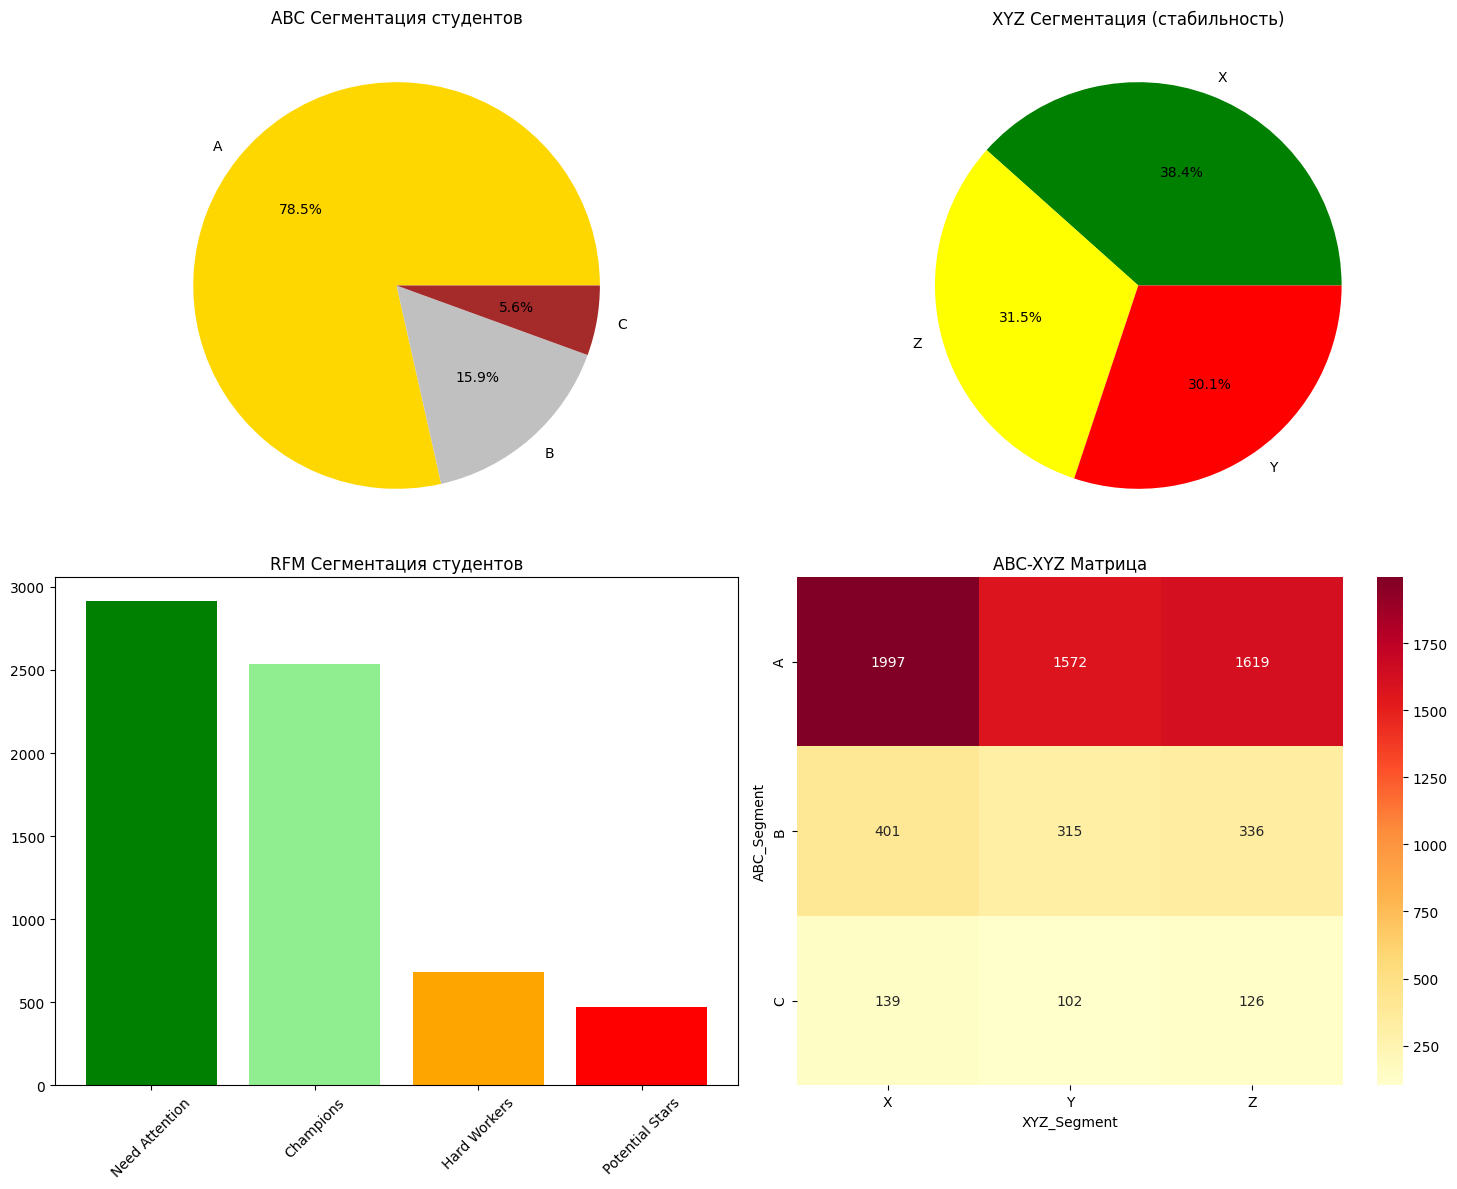

In [17]:
print("\n14. ВИЗУАЛИЗАЦИЯ СЕГМЕНТАЦИИ")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

abc_counts = df_abcxyz['ABC_Segment'].value_counts()
axes[0, 0].pie(abc_counts.values, labels=abc_counts.index, autopct='%1.1f%%', colors=['gold', 'silver', 'brown'])
axes[0, 0].set_title('ABC Сегментация студентов')

xyz_counts = df_abcxyz['XYZ_Segment'].value_counts()
axes[0, 1].pie(xyz_counts.values, labels=xyz_counts.index, autopct='%1.1f%%', colors=['green', 'yellow', 'red'])
axes[0, 1].set_title('XYZ Сегментация (стабильность)')

rfm_counts = df_abcxyz['RFM_Segment'].value_counts()
axes[1, 0].bar(rfm_counts.index, rfm_counts.values, color=['green', 'lightgreen', 'orange', 'red'])
axes[1, 0].set_title('RFM Сегментация студентов')
axes[1, 0].tick_params(axis='x', rotation=45)

abc_xyz_matrix = pd.crosstab(df_abcxyz['ABC_Segment'], df_abcxyz['XYZ_Segment'])
sns.heatmap(abc_xyz_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 1])
axes[1, 1].set_title('ABC-XYZ Матрица')

plt.tight_layout()
plt.show()

ABC-XYZ матрица демонстрирует четкую структуру распределения студентов по успеваемости и стабильности результатов. Наиболее многочисленными являются сегменты AX (1997 студентов) и AY (1572 студентов), представляющие учащихся с высокой успеваемостью и разной степенью стабильности. Вместе они формируют надежную академическую базу учреждения. При этом выделяется значительная группа BX (401 студент) — стабильных середняков с предсказуемыми результатами.

Критическими зонами внимания выступают все Z-сегменты, особенно проблемная группа CZ (126 студента), сочетающая низкую успеваемость с высокой нестабильностью. Серьезного контроля требуют также сегменты AZ (1619 студентов) и BZ (336 студентов), где нестабильность результатов наблюдается даже у успевающих учащихся. Это указывает на необходимость дифференцированного подхода: для Z-сегментов важен регулярный мониторинг и оперативная поддержка, в то время как стабильные сегменты A и B могут служить опорой для образовательного процесса.

In [18]:
print("\n15. ПОДГОТОВКА ДАННЫХ ДЛЯ ML")

df_ml = df_processed.copy()

categorical_columns_ml = df_ml.select_dtypes(include=['object']).columns

print("Категориальные признаки для кодирования:")
print(categorical_columns_ml.tolist())

df_ml_encoded = pd.get_dummies(df_ml, columns=categorical_columns_ml, drop_first=True)

print(f"Размер данных после кодирования: {df_ml_encoded.shape}")

X = df_ml_encoded.drop('Exam_Score', axis=1)
y = df_ml_encoded['Exam_Score']

print("\nПроверка типов данных:")
print(X.dtypes.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Масштабирование завершено")


15. ПОДГОТОВКА ДАННЫХ ДЛЯ ML
Категориальные признаки для кодирования:
['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Attendance_Level']
Размер данных после кодирования: (6607, 32)

Проверка типов данных:
bool       23
int64       6
float64     2
Name: count, dtype: int64
Train set: (5285, 31), Test set: (1322, 31)
Масштабирование завершено


Для осуществления машинного обучения проведена подготовка данных. На данном этапе осуществлены следующие преобразования:

- исходные категориальные признаки (текстовые значения) успешно преобразованы в числовой формат;

- данные разделены на обучающую (80%) и тестовую (20%) выборки для корректной оценки моделей;

- все признаки масштабированы, что обеспечит стабильную работу алгоритмов и сравнимые веса признаков в будущих моделях.

In [19]:
df_ml_encoded

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Study_Efficiency,Engagement_Score,Parental_Involvement_Low,...,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_Yes,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Male,Attendance_Level_Low,Attendance_Level_Medium
0,23,84,7,73,0,3,67,3.041667,61.3,True,...,False,True,False,True,False,False,True,True,False,True
1,19,64,8,59,2,4,61,2.950000,48.5,True,...,False,False,False,False,False,True,False,False,True,False
2,24,98,7,91,2,4,74,3.640000,73.0,False,...,True,False,False,False,True,False,True,True,False,False
3,29,89,8,98,1,4,71,3.266667,74.6,True,...,False,False,False,True,False,True,False,True,False,True
4,19,92,6,65,3,4,70,3.250000,59.3,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,7,76,1,2,68,2.923077,58.6,False,...,False,True,False,True,False,False,True,False,True,False
6603,23,76,8,81,3,2,69,3.375000,62.1,False,...,False,True,False,True,False,False,True,False,False,True
6604,20,90,6,65,3,2,68,3.095238,59.0,False,...,False,False,False,False,True,False,True,False,False,False
6605,10,86,6,91,2,3,68,8.272727,65.2,False,...,False,True,False,True,False,False,False,False,False,True


In [20]:
print("\n16. ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ")

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nОбучение модели: {name}")

    try:
        if name == 'Linear Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'model': model,
            'predictions': y_pred
        }

        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R2 Score: {r2:.4f}")

    except Exception as e:
        print(f"Ошибка при обучении {name}: {e}")
        continue


16. ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ

Обучение модели: Linear Regression
MAE: 0.3539
RMSE: 0.8548
R2 Score: 0.9358

Обучение модели: Random Forest
MAE: 0.9858
RMSE: 1.3854
R2 Score: 0.8314

Обучение модели: Gradient Boosting
MAE: 0.6887
RMSE: 1.0955
R2 Score: 0.8946


Следующим этапом тестируются три принципиально разных подхода к машинному обучению: линейная регрессия, случайный лес и градиентный бустинг.

Для каждой модели рассчитаны ключевые показатели качества:

- MAE (средняя абсолютная ошибка) - интерпретируемость в баллах.

- RMSE (среднеквадратичная ошибка) - чувствительность к выбросам.

- R² (коэффициент детерминации) - объясненная дисперсия.

Основная задача модели — по данным о студенте (его привычках, окружении, успеваемости) спрогнозировать итоговый балл за экзамен.


16. СРАВНЕНИЕ МОДЕЛЕЙ

Сравнение моделей:
               Model       MAE      RMSE        R2
0  Linear Regression  0.353914  0.854761  0.935829
2  Gradient Boosting  0.688731  1.095501  0.894592
1      Random Forest  0.985840  1.385415  0.831419


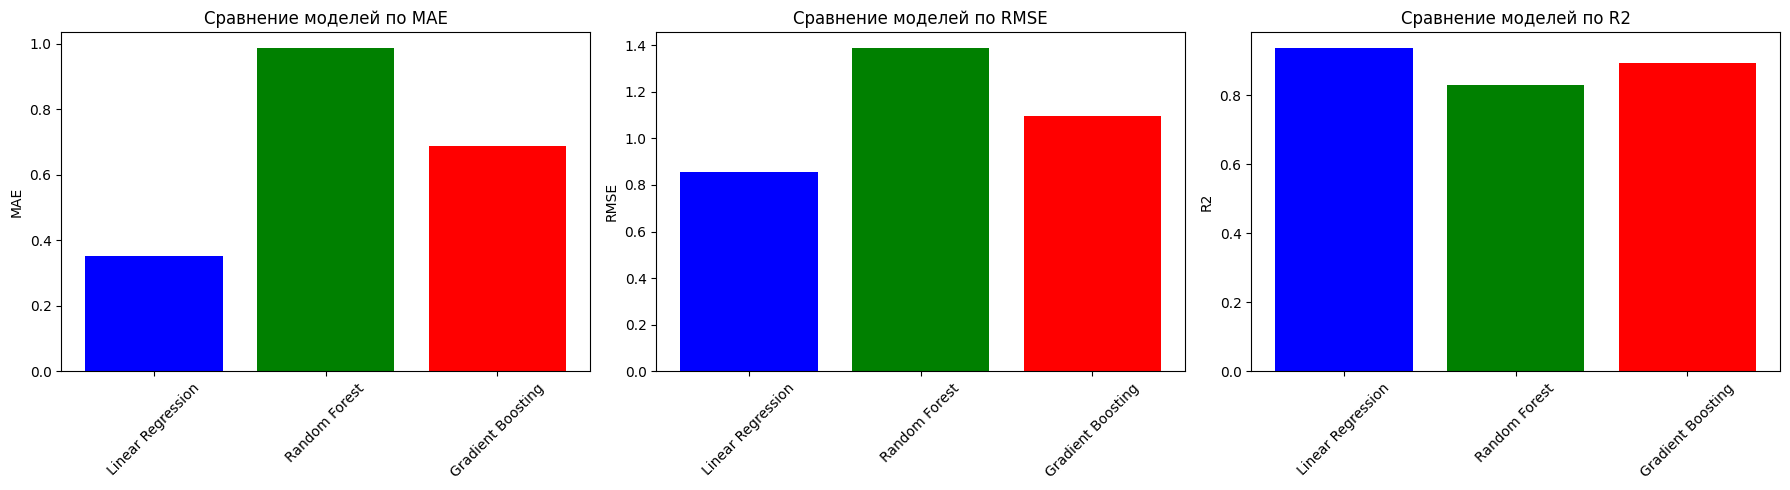

In [21]:
print("\n16. СРАВНЕНИЕ МОДЕЛЕЙ")

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['MAE'] for model in results],
    'RMSE': [results[model]['RMSE'] for model in results],
    'R2': [results[model]['R2'] for model in results]
})

print("\nСравнение моделей:")
print(comparison_df.sort_values('R2', ascending=False))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'R2']
for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df['Model'], comparison_df[metric], color=['blue', 'green', 'red'])
    axes[i].set_title(f'Сравнение моделей по {metric}')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Проведенное сравнение трех моделей машинного обучения выявило явного лидера - линейную регрессию, которая продемонстрировала превосходную точность прогнозирования экзаменационных баллов. Модель объясняет 93,6% дисперсии результатов, что свидетельствует о ее высокой предсказательной силе. Средняя ошибка прогноза составляет всего 0,35 балла, что делает модель пригодной для практического применения. Успех линейной регрессии указывает на преимущественно линейный характер взаимосвязей между признаками и целевой переменной в данных.

Градиентный бустинг показал достойные, но значительно более скромные результаты с коэффициентом детерминации 89,5%.

Случайный лес занял последнее место, вероятно, из-за переобучения или неоптимальных параметров.

Таким образом, линейная регрессия рекомендована как оптимальное решение, сочетающее высокую точность с прозрачностью интерпретации результатов.


17. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
Лучшая модель: Linear Regression

Топ-10 самых важных признаков:
                        feature  importance
1                    Attendance    1.690384
0                 Hours_Studied    1.506046
7              Engagement_Score    1.053748
10      Access_to_Resources_Low    0.803527
8      Parental_Involvement_Low    0.791616
4             Tutoring_Sessions    0.595846
9   Parental_Involvement_Medium    0.504494
22      Peer_Influence_Positive    0.501000
11   Access_to_Resources_Medium    0.498272
16            Family_Income_Low    0.493685


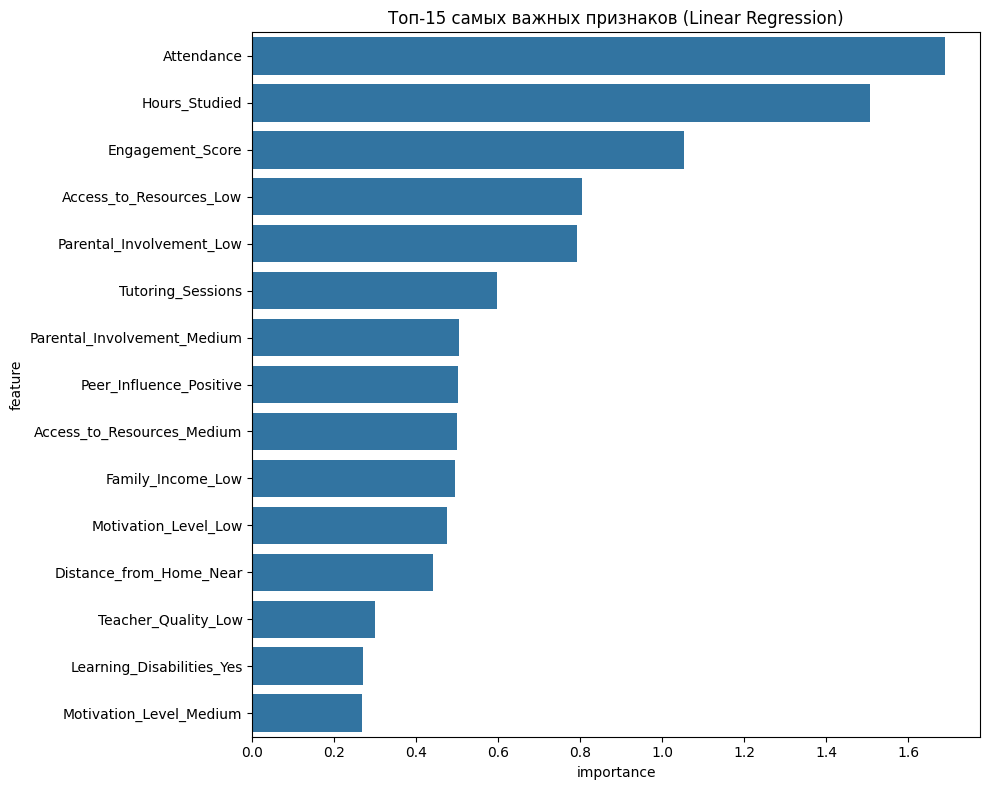

In [24]:
print("\n17. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")

best_model_name = comparison_df.loc[comparison_df['R2'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"Лучшая модель: {best_model_name}")

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(best_model.coef_)
    }).sort_values('importance', ascending=False)

else:
    print("Модель не поддерживает анализ важности признаков")
    feature_importance = None

if feature_importance is not None:
    print("\nТоп-10 самых важных признаков:")
    print(feature_importance.head(10))

    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title(f'Топ-15 самых важных признаков ({best_model_name})')
    plt.tight_layout()
    plt.show()


18. SHAP АНАЛИЗ


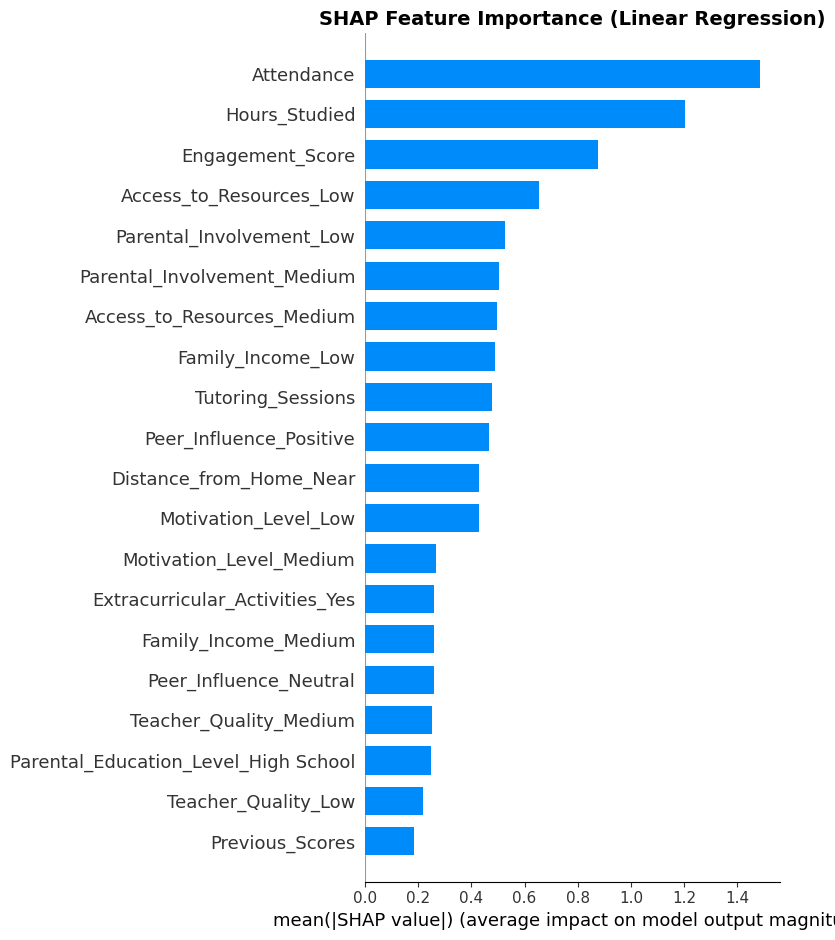

In [39]:
print("\n18. SHAP АНАЛИЗ")

try:
    import shap

    if best_model_name == 'Linear Regression':
        explainer = shap.LinearExplainer(best_model, X_train_scaled)
        shap_values = explainer.shap_values(X_test_scaled)
        features_for_shap = X_test_scaled
    else:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test)
        features_for_shap = X_test

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, features_for_shap, feature_names=X.columns, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance ({best_model_name})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

except ImportError:
    print("SHAP не установлен. Установите: pip install shap")
except Exception as e:
    print(f"Ошибка при SHAP анализе: {e}")

Анализ важности признаков проведен с применением двух моделей: SHAP и встроенных "важностей" признаков. Модели показали, что успехи студентов в учебе зависят от трех основных факторов. Самым важным оказалось регулярное посещение занятий - те, кто ходит на пары постоянно, учатся значительно лучше. Почти так же важно количество времени, выделяемое на самостоятельную подготовку, и общая вовлеченность в учебный процесс.

Интересно, что отсутствие доступа к учебным материалам и недостаточная поддержка со стороны родителей влияют на оценки сильнее, чем многие другие факторы. Положительная атмосфера в студенческом коллективе тоже играет большую роль - когда вокруг учатся мотивированные ребята, это помогает добиваться лучших результатов. При этом семейный доход оказался на последнем месте среди важных факторов.

Эти выводы подсказывают, что для улучшения успеваемости в первую очередь нужно работать с посещаемостью и создавать условия для регулярных занятий. Поддержка требуется тем, у кого нет доступа к учебникам или компьютерам, а также студентам, не получающим помощи от семьи. Создание дружеской атмосферы в группах - еще один эффективный способ помочь всем студентам учиться лучше.

In [23]:
df_processed.to_csv('StudentPerformance_Processed.csv', index=False)
df_abcxyz.to_csv('StudentPerformance_Segmented.csv', index=False)
print("\nОбработанные данные сохранены в файлы:")
print("- StudentPerformance_Processed.csv")
print("- StudentPerformance_Segmented.csv")


Обработанные данные сохранены в файлы:
- StudentPerformance_Processed.csv
- StudentPerformance_Segmented.csv
